In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import datetime as dt
from scipy.stats import skew, kurtosis
from sklearn import preprocessing, model_selection, metrics

import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
pd.options.display.max_columns = 1000

In [2]:
DATA_PATH = Path("data/")

In [3]:
train = pd.read_csv(DATA_PATH/"train.csv", parse_dates=["impression_time"])
test = pd.read_csv(DATA_PATH/"test.csv", parse_dates=["impression_time"])

view_log = pd.read_csv(DATA_PATH/"view_log.csv", parse_dates=["server_time"])
item_data = pd.read_csv(DATA_PATH/"item_data.csv")

view_log_item_data = view_log.merge(item_data, on="item_id", how="left")

In [4]:
view_log_item_data.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0
3,2018-10-15 08:58:00,android,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0
4,2018-10-15 08:58:00,android,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0


In [5]:
tmp = view_log_item_data.groupby("user_id").agg({"server_time": [("user_count", "count")],
#                                                                "device_type": [("num_device_types", lambda x: np.unique(x).size)],
                                                 "session_id": [("num_sessions", lambda x: np.unique(x).size)],
                                                 "item_id": [("num_items", lambda x: np.unique(x).size)],
                                                 "item_price": [("mean_item_price", "mean"),
                                                                ("min_item_price", "min"),
                                                                ("max_item_price", "max"),
                                                                ("sd_item_price", lambda x: np.std(x))
#                                                                                 ("skew_item_price", lambda x: skew(x)),
#                                                                                 ("kurtosis_item_price", lambda x: kurtosis(x))
                                                               ],
                                                 "category_1": [("num_category_1", lambda x: np.unique(x).size)],
                                                 "category_2": [("num_category_2", lambda x: np.unique(x).size)],
                                                 "category_3": [("num_category_3", lambda x: np.unique(x).size)],
                                                 "product_type": [("num_product_type", lambda x: np.unique(x).size)],
                                                })
tmp.columns = tmp.columns.droplevel()
tmp = tmp.reset_index(drop=False)

In [6]:
tmp1 = view_log_item_data.pivot_table(index="user_id", 
                                      columns="category_1", 
                                      values="server_time", aggfunc="count").fillna(0)
tmp1.columns.name = None
tmp1.columns = [f"category_1_{int(category_type)}" for category_type in tmp1.columns]
tmp1 = tmp1.reset_index()

In [7]:
tmp2 = view_log_item_data.pivot_table(index="user_id", 
                                      columns="category_2", 
                                      values="server_time", aggfunc="count").fillna(0)
tmp2.columns.name = None
tmp2.columns = [f"category_2_{int(category_type)}" for category_type in tmp2.columns]
tmp2 = tmp2.reset_index()

In [8]:
train["is_train"] = 1
test["is_train"] = 0

panel = pd.concat([train, test], sort=False, ignore_index=True)

In [9]:
panel.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0.0,1
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1.0,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0.0,1
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0.0,1
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0.0,1


In [10]:
panel = (panel.merge(tmp, on="user_id", how="left")
              .merge(tmp1, on="user_id", how="left")
              .merge(tmp2, on="user_id", how="left"))

In [11]:
os_version_mapper = {"latest": 2, "intermediate": 1, "old": 0}
panel["os_version"] = panel["os_version"].map(os_version_mapper)

In [12]:
panel["day"] = panel["impression_time"].dt.day
panel["dayofweek"] = panel["impression_time"].dt.dayofweek
panel["hour"] = panel["impression_time"].dt.hour

In [13]:
for col in ["user_id", "app_code", 
            ["user_id", "app_code"], ["app_code", "os_version"]]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = panel[["impression_id"] + col].copy()
    gdf = all_df.groupby(col)["impression_id"].count().reset_index()
    gdf.columns = col + [col_name+"_count"]
    panel = pd.merge(panel, gdf, on=col, how="left")

In [14]:
panel.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,user_count,num_sessions,num_items,mean_item_price,min_item_price,max_item_price,sd_item_price,num_category_1,num_category_2,num_category_3,num_product_type,category_1_0,category_1_1,category_1_2,category_1_4,category_1_5,category_1_6,category_1_7,category_1_8,category_1_9,category_1_10,category_1_11,category_1_12,category_1_13,category_1_14,category_1_15,category_1_16,category_1_17,category_2_0,category_2_1,category_2_2,category_2_3,category_2_4,category_2_5,category_2_6,category_2_7,category_2_8,category_2_9,category_2_10,category_2_11,category_2_12,category_2_13,category_2_14,category_2_15,category_2_16,category_2_17,category_2_18,category_2_19,category_2_20,category_2_21,category_2_22,category_2_23,category_2_24,category_2_25,category_2_26,category_2_27,category_2_28,category_2_29,category_2_30,category_2_31,category_2_33,category_2_34,category_2_35,category_2_36,category_2_37,category_2_38,category_2_39,category_2_40,category_2_41,category_2_42,category_2_43,category_2_44,category_2_45,category_2_46,category_2_47,category_2_48,category_2_49,category_2_50,category_2_51,category_2_52,category_2_53,category_2_54,category_2_55,category_2_56,category_2_57,category_2_58,category_2_59,category_2_60,category_2_61,category_2_62,category_2_63,category_2_64,category_2_65,category_2_66,category_2_67,category_2_68,category_2_69,category_2_70,category_2_71,category_2_72,category_2_73,category_2_74,category_2_75,category_2_76,category_2_77,category_2_78,category_2_79,day,dayofweek,hour,user_id_count,app_code_count,user_id_app_code_count,app_code_os_version_count
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,0,0,0.0,1,1,1,1,2350.000000,2350.0,2350.0,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,3,0,3,535,3,228
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,2,1,1.0,1,12,7,7,4452.833333,1024.0,14166.0,3273.840834,4.0,5.0,5.0,7.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,15,3,0,61,538,50,226
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,1,1,0.0,1,2,2,2,1598.500000,973.0,2224.0,625.500000,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,3,0,13,418,13,145
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,2,1,0.0,1,18,7,12,9963.388889,249.0,93568.0,21181.120422,9.0,11.0,10.0,12.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,3,0,4,5529,4,2671
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,2,0,0.0,1,46,24,34,8618.934783,288.0,117376.0,18421.983064,13.0,27.0,31.0,34.0,0.0,4.0,0.0,4.0,0.0,1.0,4.0,3.0,7.

In [29]:
columns_for_model = np.setdiff1d(panel.columns.values, ["day", "day_of_week",
                                                        "impression_id",
                                                        "impression_time",
                                                        "is_click",
                                                        "is_train",
                                                        "user_id"]).tolist()
train_X = panel[columns_for_model]
train_y = panel["is_train"]

In [30]:
len(columns_for_model)

116

In [31]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, dep=8, seed=0, data_leaf=511, hessian_leaf=50):  
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
#     params["max_depth"] = dep
    params["num_leaves"] = 31
    params["min_data_in_leaf"] = data_leaf
    params["min_sum_hessian_in_leaf"] = hessian_leaf
    params["learning_rate"] = 0.01
    params["bagging_fraction"] = 0.8
    params["feature_fraction"] = 0.4
    params["feature_fraction_seed"] = seed
    params["bagging_freq"] = 5
    params["bagging_seed"] = seed
    params["lambda_l2"] = 0.95
    params["lambda_l1"] = 0.95
    params["verbosity"] = -1
    num_rounds = 20000

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=200, verbose_eval=500)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    if test_X2 is not None:
        pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)
    else:
        pred_test_y2 = 0

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
        print(loss)
        return model, loss, pred_test_y, pred_test_y2
    else:
        return model, loss, pred_test_y, pred_test_y2

In [32]:
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(train_X.shape[0])
n_splits = 3
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=7988)
model_name = "lgb"
for dev_index, val_index in kf.split(train_X, train_y):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0.

    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, None, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
#     model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=450, hessian_leaf=30, seed=9873)
#     pred_val += pred_v
#     pred_test += pred_t
#     n_models += 1
    
#     model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=600, hessian_leaf=70, seed=4568)
#     pred_val += pred_v
#     pred_test += pred_t
#     n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models
    
    loss = metrics.roc_auc_score(val_y, pred_val)
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
#     break
print(np.mean(cv_scores))

Building model..
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.663536
[1000]	valid_0's auc: 0.672078
[1500]	valid_0's auc: 0.677322
[2000]	valid_0's auc: 0.68132
[2500]	valid_0's auc: 0.684739
[3000]	valid_0's auc: 0.687694
[3500]	valid_0's auc: 0.69035
[4000]	valid_0's auc: 0.692493
[4500]	valid_0's auc: 0.694576
[5000]	valid_0's auc: 0.696498


KeyboardInterrupt: 

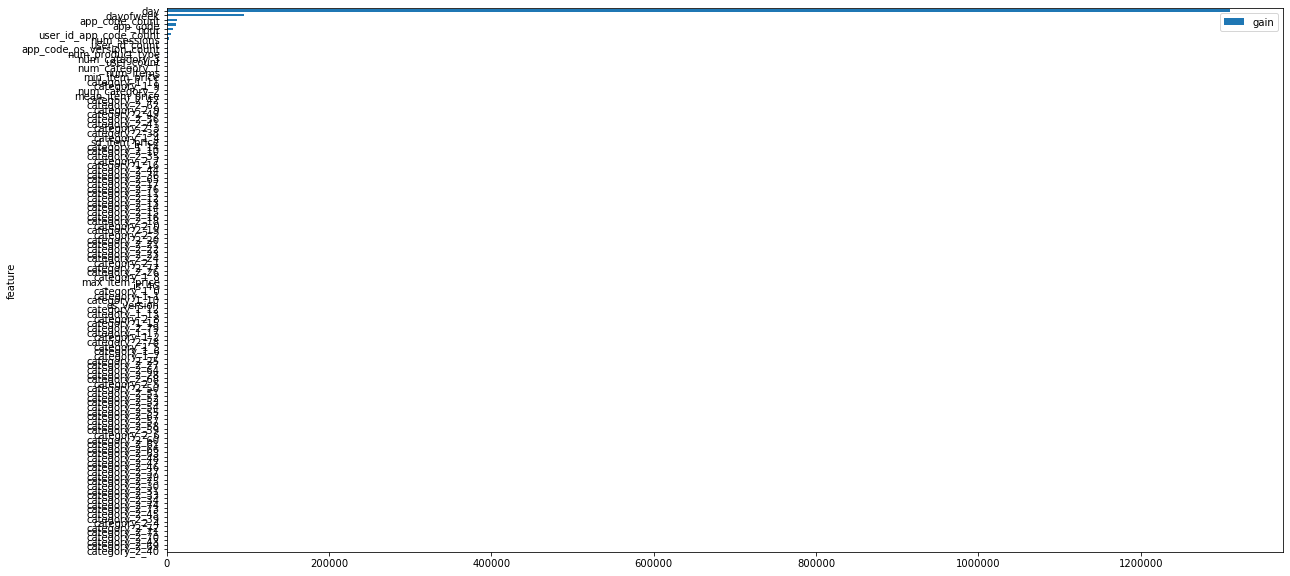

In [24]:
(pd.DataFrame({"feature": model.feature_name(), 
              "gain": model.feature_importance(importance_type="gain")})
     .sort_values("gain", ascending=True).set_index("feature").plot(kind="barh", figsize=(20,10)))

In [31]:
submit = pd.DataFrame({"impression_id": test_ids, "is_click": pred_test_full})

In [32]:
submit.head()

,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0.012996
1,caac14a5bf2ba283db7708bb34855760,0.015516
2,13f10ba306a19ce7bec2f3cae507b698,0.071492
3,39c4b4dc0e9701b55a0a4f072008fb3f,0.019360
4,bf5a572cca75f5fc67f4b14e58b11d70,0.097954


In [33]:
submit.to_csv("submissions/submit_baseline_lgb_kfold.0.7324.csv", index=False)